In [56]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from skimage import data
from skimage import transform as tf

from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.wcs import WCS
import healpy as hp

### Fetching tile

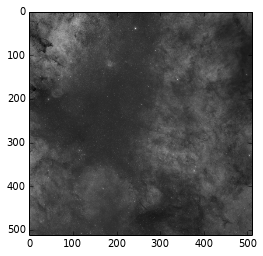

In [57]:
# hdu_list = fits.open('https://rawgithub.com/hipspy/hips-extra/master/datasets/samples/DSS2Red/Norder3/Dir0/Npix335.fits')
hdu_list = fits.open('https://rawgithub.com/hipspy/hips-extra/master/datasets/samples/DSS2Red/Norder3/Dir0/Npix450.fits')

tile_wcs = WCS(hdu_list[0].header)
tile = hdu_list[0].data.astype('float')
plt.imshow(tile, cmap='gray')
plt.show()

### Creating a WCS object

In [58]:
w = WCS(naxis=2)

skydir = SkyCoord(0, 0, unit='deg', frame='galactic')

w.wcs.ctype[0] = 'GLON-{}'.format('AIT')
w.wcs.ctype[1] = 'GLAT-{}'.format('AIT')
w.wcs.crval[0] = skydir.galactic.l.deg
w.wcs.crval[1] = skydir.galactic.b.deg

w.wcs.crpix[0] = 1000
w.wcs.crpix[1] = 500

w.wcs.cdelt[0] = -0.01
w.wcs.cdelt[1] = 0.01

w = WCS(w.to_header())

shape = (1000, 2000)
all_sky_wcs = w

### Function definition for computing HiPS tile corners

In [131]:
def compute_corners_skycoord(order, ipix):
    nside = hp.order2nside(order)
    coords = hp.boundaries(nside, ipix, nest=True)
    theta, phi = hp.vec2ang(np.transpose(coords), lonlat=False)
    radec = SkyCoord(ra=phi, dec=np.pi/2 - theta, unit='radian', frame='icrs')
    print('SkyCoord :', radec.galactic)
    pixels = np.array(radec.to_pixel(all_sky_wcs))
    return (pixels.T.reshape((4,2)))

### Function definition for drawing a  HiPS tile

In [113]:
from skimage import transform as tf
def draw_tile(warped, corners, out_shape, wcs):
    src = corners
    print('Source : ', src)
    dst = np.array([[511, 0], [511, 511], [0, 511], [0, 0]])
    tform3 = tf.ProjectiveTransform()
    tform3.estimate(src, dst)
    return warped + tf.warp(tile, tform3, output_shape=out_shape)

SkyCoord : <SkyCoord (Galactic): (l, b) in deg
    [(   2.70907683,  3.81383515), ( 355.44356947,  4.98219156),
     ( 353.36235549, -2.10918264), (   0.67390004, -3.23622577)]>
Corners:  [[  728.54880122   880.33972146]
 [ 1453.32078085   997.1604671 ]
 [ 1662.33429379   288.00518917]
 [  931.69072155   175.4190427 ]]
Source :  [[  728.54880122   880.33972146]
 [ 1453.32078085   997.1604671 ]
 [ 1662.33429379   288.00518917]
 [  931.69072155   175.4190427 ]]


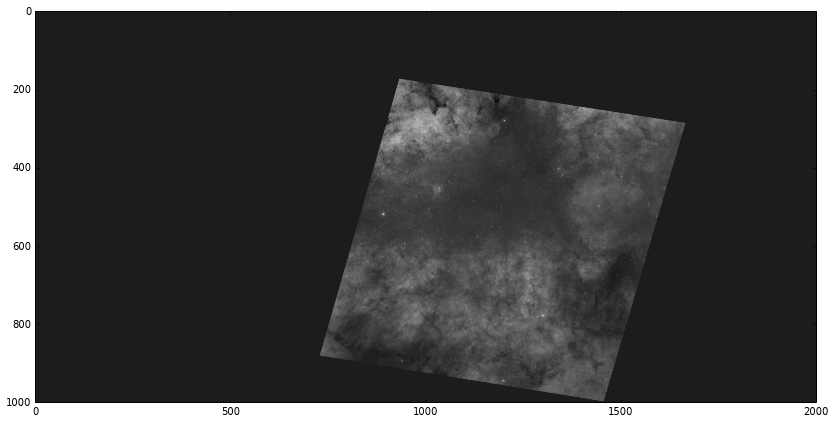

In [117]:
from astropy.visualization.wcsaxes import WCSAxes
warped = np.zeros((1000, 2000)) # the output image size

indices = [450]#, 335, 336, 368, 399, 400, 432, 463]
for index in indices:
    corners = compute_corners_skycoord(3, index)
    print('Corners: ', corners)
    warped = draw_tile(warped, corners, warped.shape, wcs1)
fig, ax = plt.subplots(nrows=1, figsize=(14, 14))

ax.imshow(warped, origin='upper', cmap=plt.cm.gray)
